In [2]:
import random as rand
import warnings

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
import pylab as pl
from IPython import display

from datetime import datetime, timedelta
import time
import random as rand
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv").drop(labels=['Lat','Long'],axis=1)
df = pd.melt(df, id_vars=['Province/State','Country/Region'], var_name='date', value_name='cases')
df['date'] = df['date'].astype('datetime64')

total = df.groupby('date').sum().reset_index()

In [4]:
POP = 1000000     # assume population 1 mil
CONTACT = 4              # people in contact per day
INFECT_CHANCE = 0.054    # chance of being infected when close to person in radius
FLIGHTS = 34.2/264/365   # flights per day
ASYM = 0.505             # % of being asymptomatic while infected

# flights source = https://centreforaviation.com/analysis/reports/indonesia-international-aviation-rapid-growth-and-strong-competition-410927

In [5]:
 age = ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '85'] 

hosl = [1.6, 14.3, 21.2, 20.5, 28.6, 30.5, 31.3]
hosu = [2.5, 20.8, 28.3, 30.1, 43.5, 58.7, 70.3]

icul = [0, 2, 5.4, 4.7, 8.1, 10.5, 6.3];   icul = [a*100/b for a,b in zip(icul,hosl)]
icuu = [0, 4.2, 10.4, 11.2, 18.8, 31, 29]; icuu = [a*100/b for a,b in zip(icuu,hosu)]

fatl = [0, 0.1, 0.5, 1.4, 2.7, 4.3, 10.4];  #fatl = [0 if b==0 else a*100/b for a,b in zip(fatl,icul)]
fatu = [0, 0.2, 0.8, 2.6, 4.9, 10.5, 27.3]; #fatu = [0 if b==0 else a*100/b for a,b in zip(fatu,icuu)]

indo = [433, 521, 169, 120, 67, 19, 15]


ageb = pd.DataFrame(list(zip(age,hosl,hosu,icul,icuu,fatl,fatu,indo)), 
        columns =['age','hosl','hosu','icul','icuu','fatl','fatu','indo'])


In [6]:
df = pd.DataFrame()
for i,row in ageb.iterrows():
    temp = pd.DataFrame()
    temp['age'] = [row['age']]*(( row['indo']*POP)//1329)
    df = df.append(temp)
    
df = df['age'].sample(n=POP)
data = pd.merge(left=df, right=ageb, how='left', left_on='age', right_on='age')
data = data.dropna()
data['status'] = 'S'
data.drop('indo', axis=1, inplace=True)
data

,age,hosl,hosu,icul,icuu,fatl,fatu,status
0,20-44,14.3,20.8,13.986014,20.192308,0.1,0.2,S
1,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S
2,55-64,20.5,30.1,22.926829,37.209302,1.4,2.6,S
3,20-44,14.3,20.8,13.986014,20.192308,0.1,0.2,S
4,20-44,14.3,20.8,13.986014,20.192308,0.1,0.2,S
...,...,...,...,...,...,...,...,...
999995,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S
999996,20-44,14.3,20.8,13.986014,20.192308,0.1,0.2,S
999997,55-64,20.5,30.1,22.926829,37.209302,1.4,2.6,S
999998,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S


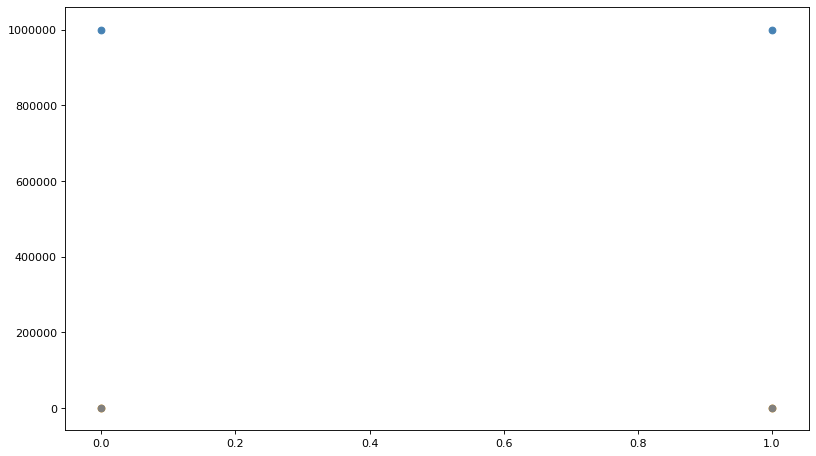

1 999619 381 0


KeyboardInterrupt: 

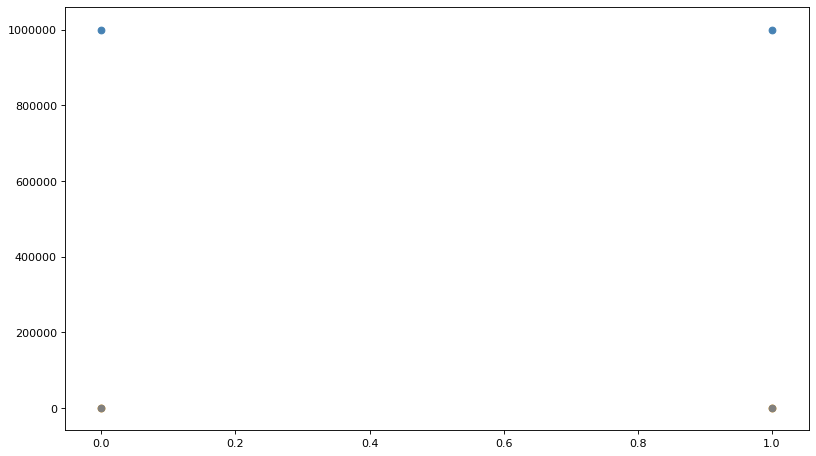

In [7]:
t = time.time()
df = data.copy()
df['t'] = None; df['r_time'] = None
result = pd.DataFrame()
fig=plt.figure(figsize=(12, 7), dpi= 80, facecolor='w', edgecolor='k')
    
for t in range(100):
    S = df.loc[df['status']=='S','status'].shape[0]
    I = df.loc[df['status']=='I','status'].shape[0]
    R = df.loc[df['status']=='R','status'].shape[0]
    
    pl.scatter(t, I, c='orange')
    pl.scatter(t, S+I, c='steelblue')
    pl.scatter(t, R, c='gray')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
    print(t,S,I,R)
    # cross infection
    ind =  df.index[(df['status']=='S' )].tolist()
    if len(ind):
        df.loc[ind, ['status','t','r_time']] = [['I',t, min(24,x)] if rand.random() < INFECT_CHANCE*I*CONTACT/POP 
                                            else ['S',None,None] for x in np.random.poisson(15,len(ind))]
    
    # imported cases
    if t <= 15:
        fcase = np.random.binomial(S, FLIGHTS)
        findex = rand.sample(range(POP), fcase)
        findex = df.loc[(df.index.isin(findex))&(df['status']=='S')].index
        if len(findex):
            df.loc[findex, ['status','t','r_time']] = [['I',t, min(24,x)] for x in np.random.poisson(15,len(findex))]
    
    df.loc[df['r_time'] <= t - df['t'], 'status']='R'

plt.legend(['Infected','Susceptible','Recovered/Death'])
plt.xlabel('Time')
plt.ylabel('Number of people')